In [89]:
!hostname

cn7


In [90]:
import torch.nn as nn
import functools
import torch
import numpy as np
from matplotlib import pyplot as plt
import numba_scipy
import gc
import os
from utils import save_checkpoint_withEval as save_checkpoint
from utils import restore_checkpoint_withEval as restore_checkpoint
import datasets
import tensorflow as tf
from torch.utils.cpp_extension import load
from models import ncsnpp
from configs.vp import cifar10_ncsnpp_continuous as configLoader
from models import utils as mutils
from models.ema import ExponentialMovingAverage

In [91]:
relu = nn.functional.softplus

### Loading the ML model from Song et al.

In [92]:
config =  configLoader.get_config()
config.training.batch_size=128
config.training.snapshot_freq_for_preemption=1000
config.training.snapshot_freq=50000
config.training.log_freq=5

### Specify observation times

In [93]:
data = np.load('20221102-linearDegradation-cifar10-newSchedule-files.npz', allow_pickle=True)
cumSolArray=data['cumSolArray']
brTable=data['brTable']
observationTimes=data['observationTimes']

In [94]:
tEnd = observationTimes[-1]
T = len(observationTimes)
observationTimes = np.hstack((0, observationTimes))

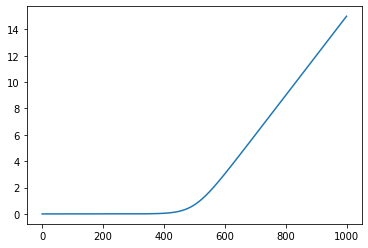

In [95]:
plt.plot(observationTimes)

### Load the trained model

In [96]:
score_model = mutils.create_model(config)
score_fn = mutils.get_model_fn(score_model, train=True)
optimizer = torch.optim.Adam(score_model.parameters(),lr=config.optim.lr) 
ema = ExponentialMovingAverage(score_model.parameters(), decay=config.model.ema_rate)
state = dict(optimizer=optimizer, model=score_model, ema=ema, lossHistory=[], step=0)

workdir = 'linearDegradation-cifar10-MLE-v2'

checkpoint_dir = os.path.join(workdir, "checkpoints")
checkpoint_meta_dir = os.path.join(workdir, "checkpoints-meta", "checkpoint.pth")
tf.io.gfile.makedirs(checkpoint_dir)
tf.io.gfile.makedirs(os.path.dirname(checkpoint_meta_dir))
state = restore_checkpoint(checkpoint_meta_dir, state, config.device)
initial_step = int(state['step'])
lossHistory = state['lossHistory']
evalLossHistory = state['evalLossHistory']
ema.copy_to(score_model.parameters())

### Visualize train/test loss

In [97]:
def emaFunc(x, r):
    
    output = np.zeros_like(x)
    
    output[0] = x[0]
    
    for i in range(1, len(x)):
        
        output[i] = (1.0-r)*output[i-1] + (r)*x[i]
        
    return output

Text(0.5, 1.0, 'Iteration=231003')

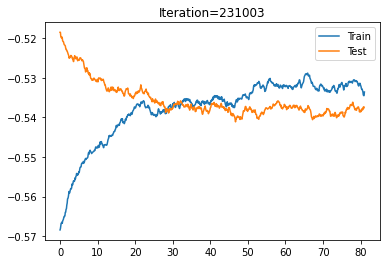

In [98]:
fig = plt.figure()
onset = 150_000
samplingRate = 100
emaRate = 0.01
plt.plot(1./1000*samplingRate*np.arange(len(lossHistory[onset::samplingRate][:])), np.array(emaFunc(lossHistory[onset::samplingRate][:],emaRate)), label='Train')
plt.plot(1./1000*samplingRate*np.arange(len(evalLossHistory[onset//samplingRate:])), np.array(emaFunc(evalLossHistory[onset//samplingRate:], emaRate)), label='Test')
#plt.gca().set_yscale('log')
#plt.gca().set_xlim([0,1400])
#plt.gca().set_ylim([-365,-350])
plt.legend(loc='best')
plt.title(f'Iteration={len(lossHistory)}')


### Generating samples

In [99]:
from scipy.stats import binom,poisson

from time import time

In [100]:
generation='binomial'

In [101]:
# Poisson sampling, GPU implementation
# skipped 4

observationTimesGPU = torch.from_numpy(observationTimes[1:]).to(config.device)

targetN = 128
ensN = 128
skipped=1

torch.cuda.set_device(config.device)
batchN = int(np.ceil(targetN/ensN))
state = torch.cuda.FloatTensor(ensN*batchN, 3,32,32).zero_()
identity = torch.from_numpy(np.ones((ensN,))).long().to(config.device)
u = torch.cuda.FloatTensor(ensN,3,32,32,256).uniform_()

n_ma = np.zeros((ensN,3,32,32,256))

summary = []

with torch.no_grad():
    
    for jj in range(batchN):
    
        t0 = time()
        
        for i in range(T-1, -1, -skipped):

            if np.mod(i+1,50)==0:
                
                print(f'reverse pass, tIndex={i}, t={observationTimes[i]}, {torch.max(state).detach().cpu().numpy()}')
            
            t = observationTimes[i+1]
            s = observationTimes[i+1-skipped]

            pt = np.exp(-t)
            ps = np.exp(-s)
            
            width = 1.0
            mean_v = 255.0/2*pt
            
            ind = i*identity
            
            
            dn = relu(score_fn((state[jj*ensN:(jj+1)*ensN,:,:,:]-mean_v)/width, ind))
            
            # Binomial bride sampling, GPU implementation
            
            if generation=='binomial':
                
                dnNP = np.clip(np.round(dn.detach().cpu().numpy()).astype('int'), 0, 255-np.round(state[jj*ensN:(jj+1)*ensN,:,:,:].detach().cpu().numpy())).astype('int')

                pp = (np.exp(-s) - np.exp(-t))/(1-np.exp(-t))

                drawNP = binom(dnNP, pp).rvs() 
                
            elif generation=='poisson':
                
                drawNP = poisson(dn.detach().cpu().numpy() * (ps-pt)/(1-pt)).rvs() 
                
            else:
                
                raise NotImplementedError(f'Sampling method is not implemented.')
            
            state[jj*ensN:(jj+1)*ensN,:,:,:] = (state[jj*ensN:(jj+1)*ensN,:,:,:] + torch.from_numpy(drawNP).to(config.device)).clip(0,255)
    
    
        t1 = time()
        print( f'round {jj}, time elapsed={t1-t0}')            

reverse pass, tIndex=999, t=14.969967708119334, 0.0
reverse pass, tIndex=949, t=13.468470886774513, 1.0
reverse pass, tIndex=899, t=11.966973155138385, 1.0
reverse pass, tIndex=849, t=10.46549380653063, 2.0
reverse pass, tIndex=799, t=8.964091702214684, 3.0
reverse pass, tIndex=749, t=7.463036386320435, 3.0
reverse pass, tIndex=699, t=5.963534957536676, 6.0
reverse pass, tIndex=649, t=4.470961579779113, 12.0
reverse pass, tIndex=599, t=3.0085795690859207, 26.0
reverse pass, tIndex=549, t=1.665955863657349, 71.0
reverse pass, tIndex=499, t=0.6708782690580674, 158.0
reverse pass, tIndex=449, t=0.193081985311412, 228.0
reverse pass, tIndex=399, t=0.04636003280654571, 253.0
reverse pass, tIndex=349, t=0.010516473967660747, 255.0
reverse pass, tIndex=299, t=0.002352615792525441, 255.0
reverse pass, tIndex=249, t=0.0005246313526043264, 255.0
reverse pass, tIndex=199, t=0.00011690927927691614, 255.0
reverse pass, tIndex=149, t=2.604803182822359e-05, 255.0
reverse pass, tIndex=99, t=5.80344039

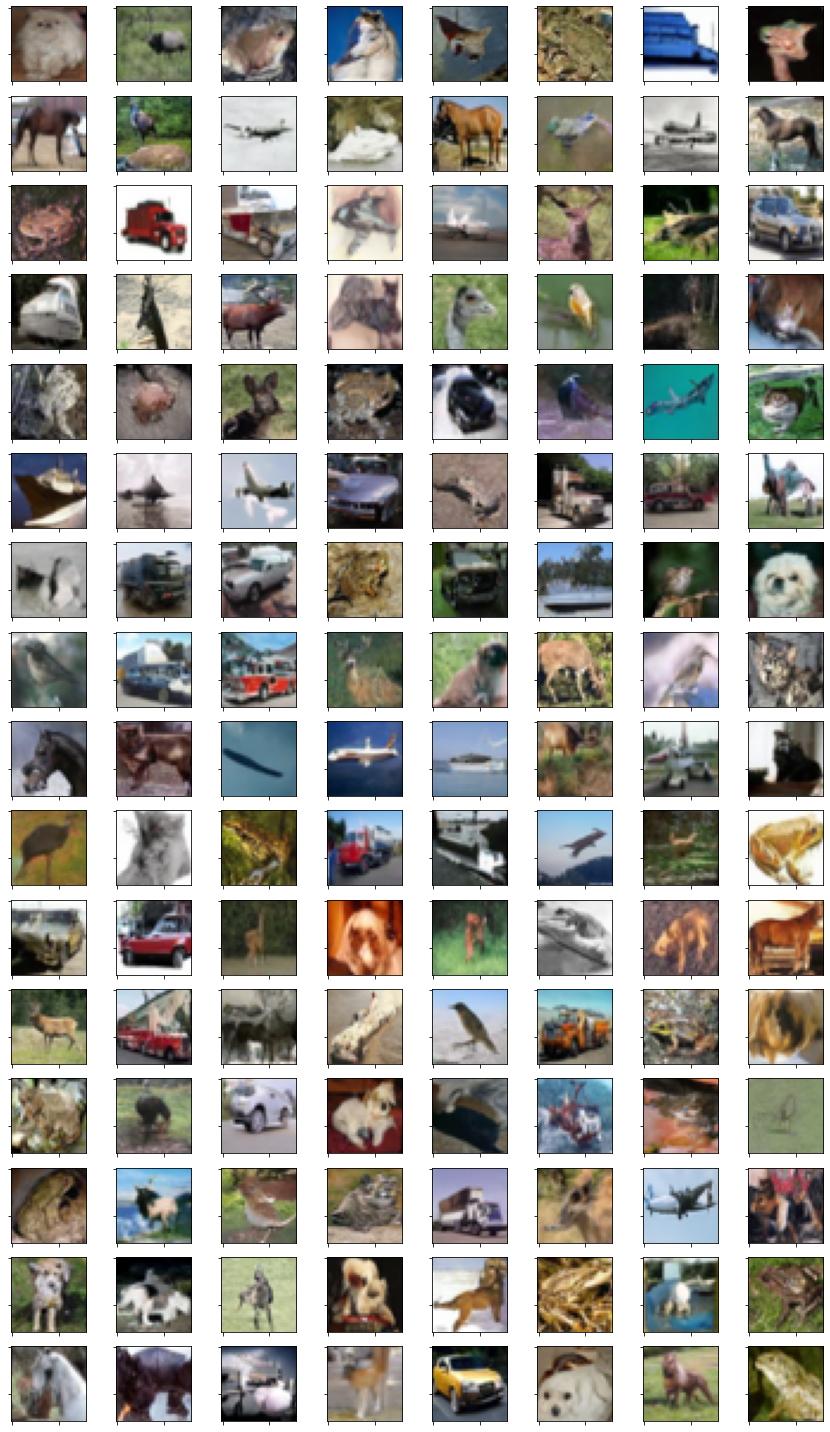

In [102]:
factor = ensN //64

factor = ensN //64

totalState = state.detach().cpu().numpy()

fig,ax=plt.subplots(8*factor,8,figsize=(12,10*factor))

for i in range(8*factor):
    for j in range(8):
        ax[i,j].imshow( np.transpose(totalState[8*i+j,:,:,:], [1,2,0]).astype('uint8') )
        #ax[i,j].set_title(str(8*i+j))
        ax[i,j].set_xticklabels([])
        ax[i,j].set_yticklabels([])
        
fig.tight_layout()
fig.savefig('linearDegradation-MLE-v2-temp-64.png',dpi=200)

In [ ]:
observationTimesGPU = torch.from_numpy(observationTimes[1:]).to(config.device)

targetN = 50_000
ensN = 512
skipped=1

torch.cuda.set_device(config.device)
batchN = int(np.ceil(targetN/ensN))
state = torch.cuda.FloatTensor(ensN*batchN, 3,32,32).zero_()
identity = torch.from_numpy(np.ones((ensN,))).long().to(config.device)
u = torch.cuda.FloatTensor(ensN,3,32,32,256).uniform_()

n_ma = np.zeros((ensN,3,32,32,256))

summary = []

with torch.no_grad():
    
    for jj in range(batchN):
    
        t0 = time()
        
        for i in range(T-1, -1, -skipped):

            if np.mod(i+1,50)==0:
                
                print(f'reverse pass, tIndex={i}, t={observationTimes[i]}, {torch.max(state).detach().cpu().numpy()}')
            
            t = observationTimes[i+1]
            s = observationTimes[i+1-skipped]

            pt = np.exp(-t)
            ps = np.exp(-s)
            
            width = 1.0
            mean_v = 255.0/2*pt
            
            ind = i*identity
            
            
            dn = relu(score_fn((state[jj*ensN:(jj+1)*ensN,:,:,:]-mean_v)/width, ind))
            
            # Binomial bride sampling, GPU implementation
            
            if generation=='binomial':
                
                dnNP = np.clip(np.round(dn.detach().cpu().numpy()).astype('int'), 0, 255-np.round(state[jj*ensN:(jj+1)*ensN,:,:,:].detach().cpu().numpy())).astype('int')

                pp = (np.exp(-s) - np.exp(-t))/(1-np.exp(-t))

                drawNP = binom(dnNP, pp).rvs() 
                
            elif generation=='poisson':
                
                drawNP = poisson(dn.detach().cpu().numpy() * (ps-pt)/(1-pt)).rvs() 
                
            else:
                
                raise NotImplementedError(f'Sampling method is not implemented.')
            
            state[jj*ensN:(jj+1)*ensN,:,:,:] = (state[jj*ensN:(jj+1)*ensN,:,:,:] + torch.from_numpy(drawNP).to(config.device)).clip(0,255)
    
    
        t1 = time()
        print( f'round {jj}, time elapsed={t1-t0}')            

totalState = state.detach().cpu().numpy()
generatedFileName=f'linearDegradation-MLE-v2-{generation}-samples-uint8-{targetN}'
np.savez(generatedFileName, np.transpose(totalState[:targetN, :, :, :], (0,2,3,1)).astype('uint8'))
generatedFileName += '.npz'
print('saved:  '+ generatedFileName)